<a href="https://colab.research.google.com/github/jai2shan/TSAI_END2/blob/main/Session%203/Session_3_Pytorch%2081%20accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from torchvision import datasets
datasets.MNIST('data', download=True)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train

In [22]:

# import torch
# train = torch.load("/content/data/MNIST/processed/training.pt")
# randInt = torch.randint(0,9,(60000,))

# import torch
# from torch.utils.data import DataLoader

# class CustomLoader_MNIST(DataLoader):
#     def __init__(self,pt_path):
#         self.path = pt_path
#         self.data = torch.load(self.path)
        

#     def __getitem__(self, index):
#       print(self.data)
#       r = self.data.iloc[index]
#       randInt = torch.randint(0,9,(r.shape[0],))

#       image, label = r
#       output = torch.cat((label.reshape(len(label),-1),
#                           (label + randInt).reshape(len(label),-1)),
#                          dim = 1)
#       x = torch.empty(size=(len(randInt), 28,28))
#       for i in range(len(randInt)):
#           x[i] = randInt[i]*torch.ones(28,28)
          
#       input = torch.cat((image, x),dim = 1)
#       return output, input

#     def __len__(self):
#       return len(self.data)

# train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
# test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

In [23]:
import torch
train = torch.load("/content/data/MNIST/processed/training.pt")
randInt = torch.randint(0,9,(60000,))

import torch
from torch.utils.data import DataLoader

class CustomLoader_MNIST(DataLoader):
    def __init__(self,pt_path):
        self.path = pt_path
        self.data = torch.load(self.path)
        

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      image, label = self.data[0][idx], self.data[1][idx] 

      randInt = torch.randint(0,9,(1,))
      x1, x2, y1, y2 = image.reshape(1,28,28), randInt, label, label + randInt[0]

      return x1, x2, y1, y2

    def __len__(self):
      return len(self.data[0])

train_data = CustomLoader_MNIST("/content/data/MNIST/processed/training.pt")
test_data = CustomLoader_MNIST("/content/data/MNIST/processed/test.pt")

In [24]:
torch.manual_seed(1)
batch_size = 512
use_cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, **kwargs)

In [25]:
from tqdm import tqdm
pbar = tqdm(train_loader)
device = torch.device("cuda" if use_cuda else "cpu")
for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    x1, x2, y1, y2 = x1.to(device), x2.to(device), y1.to(device), y2.to(device)
    pbar.set_description(desc= f'batch_id={batch_idx}')

batch_id=117: 100%|██████████| 118/118 [00:01<00:00, 65.50it/s]


In [26]:
import torch.nn.functional as F
import torch.nn as nn
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) 

        self.dropout = nn.Dropout(dropout_value)
        # self.relu = nn.ReLU()
        self.ln1 = nn.Linear(11,19)

    def forward(self, img, rnum):        
        img = self.convblock1(img)
        img = self.convblock2(img)
        img = self.convblock3(img)
        img = self.pool1(img)
        img = self.convblock4(img)
        img = self.convblock5(img)
        img = self.convblock6(img)
        img = self.convblock7(img)
        img = self.gap(img)        
        img = self.convblock8(img)
        
        img = img.view(-1, 10)
        rnum = torch.cat((img, rnum), dim=1)
        rnum = self.ln1(rnum)

        img = F.log_softmax(img, dim=-1)
        rnum = F.log_softmax(rnum, dim=-1)
        return img, rnum

In [27]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
# summary(model, input_size=((1, 28, 28),1))

cuda


In [28]:
from tqdm import tqdm

train_losses = []
test_losses =  []
train_acc =  {'Image': [], 'RandomNumber': []}
test_acc = {'Image': [], 'RandomNumber': []}


def train(model, device, train_loader, optimizer, epoch,loss1_,loss2_):

  model.train()
  pbar = tqdm(train_loader)
  correct1 = 0
  processed = 0
  correct2 = 0

  for batch_idx, (x1, x2, y1, y2) in enumerate(pbar):
    # Data
    x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
    # Init
    
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict

    y1_pred, y2_pred = model(x1, x2)

    # Calculate loss
    loss1 = F.nll_loss(y1_pred, y1)
    loss2 = F.nll_loss(y2_pred, y2)

    # Cross Entropy Loss
    # loss1 = loss1_(y1_pred, y1)
    # loss2 = loss2_(y2_pred, y2)

    loss =  torch.add(loss1, loss2*2)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred1 = y1_pred.argmax(dim=1, keepdim=True)
    pred2 = y2_pred.argmax(dim=1, keepdim=True)
    
    # get the index of the max log-probability
    correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
    correct2 += pred2.eq(y2.view_as(pred2)).sum().item()
    processed += len(x1)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy_digit={100*correct1/processed:0.2f} Accuracy_Rnum={100*correct2/processed:0.2f}')
    train_acc['Image'].append(100*correct1/processed)
    train_acc['RandomNumber'].append(100*correct2/processed)

def test(model, device, test_loader):
    model.eval()
    correct1 = 0
    correct2 = 0
    with torch.no_grad():
        for x1, x2, y1, y2 in test_loader:
            x1, x2, y1, y2 = x1.float().to(device), x2.float().to(device), y1.to(device), y2.to(device)
            y1_pred, y2_pred = model(x1, x2)
            
            pred1 = y1_pred.argmax(dim=1, keepdim=True)
            pred2 = y2_pred.argmax(dim=1, keepdim=True)
            correct1 += pred1.eq(y1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(y2.view_as(pred2)).sum().item()

    print('Test set: Accuracy_digit={} Accuracy_Rnum={}'.format(100*correct1/len(test_loader.dataset),100*correct2/len(test_loader.dataset)))
    test_acc['Image'].append(100*correct1/len(test_loader.dataset))
    test_acc['RandomNumber'].append(100*correct2/len(test_loader.dataset))

In [29]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)

loss1_ = nn.CrossEntropyLoss()
loss2_ = nn.CrossEntropyLoss()

EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch,loss1_,loss2_)
    test(model, device, test_loader)

  0%|          | 0/118 [00:00<?, ?it/s]

EPOCH: 0


Loss=4.701635837554932 Batch_id=117 Accuracy_digit=59.61 Accuracy_Rnum=13.89: 100%|██████████| 118/118 [00:02<00:00, 44.73it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=89.59 Accuracy_Rnum=20.42
EPOCH: 1


Loss=3.848229169845581 Batch_id=117 Accuracy_digit=93.95 Accuracy_Rnum=26.22: 100%|██████████| 118/118 [00:02<00:00, 45.80it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=96.71 Accuracy_Rnum=29.03
EPOCH: 2


Loss=3.643430709838867 Batch_id=117 Accuracy_digit=96.26 Accuracy_Rnum=32.90: 100%|██████████| 118/118 [00:02<00:00, 46.86it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.6 Accuracy_Rnum=32.9
EPOCH: 3


Loss=3.0862464904785156 Batch_id=117 Accuracy_digit=97.05 Accuracy_Rnum=38.09: 100%|██████████| 118/118 [00:02<00:00, 46.16it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.22 Accuracy_Rnum=38.74
EPOCH: 4


Loss=2.789008855819702 Batch_id=117 Accuracy_digit=97.32 Accuracy_Rnum=41.19: 100%|██████████| 118/118 [00:02<00:00, 44.94it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=97.25 Accuracy_Rnum=40.66
EPOCH: 5


Loss=3.040469169616699 Batch_id=117 Accuracy_digit=97.63 Accuracy_Rnum=43.70: 100%|██████████| 118/118 [00:02<00:00, 44.44it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.08 Accuracy_Rnum=47.7
EPOCH: 6


Loss=3.067349910736084 Batch_id=117 Accuracy_digit=97.81 Accuracy_Rnum=46.76: 100%|██████████| 118/118 [00:02<00:00, 45.44it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.44 Accuracy_Rnum=48.85
EPOCH: 7


Loss=2.8384110927581787 Batch_id=117 Accuracy_digit=97.85 Accuracy_Rnum=48.00: 100%|██████████| 118/118 [00:02<00:00, 46.51it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.86 Accuracy_Rnum=54.51
EPOCH: 8


Loss=2.9048147201538086 Batch_id=117 Accuracy_digit=98.05 Accuracy_Rnum=50.08: 100%|██████████| 118/118 [00:02<00:00, 45.35it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.75 Accuracy_Rnum=51.08
EPOCH: 9


Loss=2.6702141761779785 Batch_id=117 Accuracy_digit=98.14 Accuracy_Rnum=50.47: 100%|██████████| 118/118 [00:02<00:00, 46.74it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.82 Accuracy_Rnum=49.41
EPOCH: 10


Loss=2.2669835090637207 Batch_id=117 Accuracy_digit=98.21 Accuracy_Rnum=52.07: 100%|██████████| 118/118 [00:02<00:00, 46.73it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.8 Accuracy_Rnum=51.75
EPOCH: 11


Loss=2.717595100402832 Batch_id=117 Accuracy_digit=98.28 Accuracy_Rnum=52.98: 100%|██████████| 118/118 [00:02<00:00, 45.72it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.52 Accuracy_Rnum=53.81
EPOCH: 12


Loss=2.7420196533203125 Batch_id=117 Accuracy_digit=98.27 Accuracy_Rnum=53.74: 100%|██████████| 118/118 [00:02<00:00, 45.87it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.68 Accuracy_Rnum=57.01
EPOCH: 13


Loss=2.456355571746826 Batch_id=117 Accuracy_digit=98.31 Accuracy_Rnum=55.38: 100%|██████████| 118/118 [00:02<00:00, 45.31it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.8 Accuracy_Rnum=57.34
EPOCH: 14


Loss=2.573946952819824 Batch_id=117 Accuracy_digit=98.40 Accuracy_Rnum=56.65: 100%|██████████| 118/118 [00:02<00:00, 45.49it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.8 Accuracy_Rnum=60.36
EPOCH: 15


Loss=2.6238691806793213 Batch_id=117 Accuracy_digit=98.35 Accuracy_Rnum=57.05: 100%|██████████| 118/118 [00:02<00:00, 46.42it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=62.33
EPOCH: 16


Loss=2.427891492843628 Batch_id=117 Accuracy_digit=98.51 Accuracy_Rnum=58.38: 100%|██████████| 118/118 [00:02<00:00, 46.11it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.9 Accuracy_Rnum=58.65
EPOCH: 17


Loss=2.5332298278808594 Batch_id=117 Accuracy_digit=98.47 Accuracy_Rnum=58.41: 100%|██████████| 118/118 [00:02<00:00, 46.14it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.73 Accuracy_Rnum=61.48
EPOCH: 18


Loss=2.227017641067505 Batch_id=117 Accuracy_digit=98.51 Accuracy_Rnum=59.13: 100%|██████████| 118/118 [00:02<00:00, 44.15it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.8 Accuracy_Rnum=62.2
EPOCH: 19


Loss=2.356217861175537 Batch_id=117 Accuracy_digit=98.51 Accuracy_Rnum=60.80: 100%|██████████| 118/118 [00:02<00:00, 44.77it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.97 Accuracy_Rnum=62.57
EPOCH: 20


Loss=2.4479596614837646 Batch_id=117 Accuracy_digit=98.59 Accuracy_Rnum=60.77: 100%|██████████| 118/118 [00:02<00:00, 44.07it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.98 Accuracy_Rnum=66.49
EPOCH: 21


Loss=2.3362834453582764 Batch_id=117 Accuracy_digit=98.63 Accuracy_Rnum=61.49: 100%|██████████| 118/118 [00:02<00:00, 46.87it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.74 Accuracy_Rnum=61.28
EPOCH: 22


Loss=2.2856037616729736 Batch_id=117 Accuracy_digit=98.61 Accuracy_Rnum=62.22: 100%|██████████| 118/118 [00:02<00:00, 47.63it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.91 Accuracy_Rnum=63.98
EPOCH: 23


Loss=2.0603573322296143 Batch_id=117 Accuracy_digit=98.63 Accuracy_Rnum=62.20: 100%|██████████| 118/118 [00:02<00:00, 44.60it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.86 Accuracy_Rnum=65.41
EPOCH: 24


Loss=2.2744786739349365 Batch_id=117 Accuracy_digit=98.73 Accuracy_Rnum=62.48: 100%|██████████| 118/118 [00:02<00:00, 45.17it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.92 Accuracy_Rnum=62.23
EPOCH: 25


Loss=2.077130079269409 Batch_id=117 Accuracy_digit=98.62 Accuracy_Rnum=62.61: 100%|██████████| 118/118 [00:02<00:00, 44.94it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.85 Accuracy_Rnum=69.41
EPOCH: 26


Loss=2.343250274658203 Batch_id=117 Accuracy_digit=98.65 Accuracy_Rnum=63.26: 100%|██████████| 118/118 [00:02<00:00, 45.10it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.77 Accuracy_Rnum=64.73
EPOCH: 27


Loss=2.071636915206909 Batch_id=117 Accuracy_digit=98.64 Accuracy_Rnum=64.19: 100%|██████████| 118/118 [00:02<00:00, 46.04it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.04 Accuracy_Rnum=64.21
EPOCH: 28


Loss=2.149380922317505 Batch_id=117 Accuracy_digit=98.75 Accuracy_Rnum=64.20: 100%|██████████| 118/118 [00:02<00:00, 45.24it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=65.06
EPOCH: 29


Loss=2.016672372817993 Batch_id=117 Accuracy_digit=98.70 Accuracy_Rnum=65.16: 100%|██████████| 118/118 [00:02<00:00, 45.31it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.91 Accuracy_Rnum=63.64
EPOCH: 30


Loss=2.055828332901001 Batch_id=117 Accuracy_digit=98.75 Accuracy_Rnum=65.14: 100%|██████████| 118/118 [00:02<00:00, 45.75it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.93 Accuracy_Rnum=68.06
EPOCH: 31


Loss=2.2845451831817627 Batch_id=117 Accuracy_digit=98.78 Accuracy_Rnum=66.00: 100%|██████████| 118/118 [00:02<00:00, 45.20it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.99 Accuracy_Rnum=69.47
EPOCH: 32


Loss=1.934841513633728 Batch_id=117 Accuracy_digit=98.74 Accuracy_Rnum=66.81: 100%|██████████| 118/118 [00:02<00:00, 44.29it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.08 Accuracy_Rnum=67.69
EPOCH: 33


Loss=1.9732989072799683 Batch_id=117 Accuracy_digit=98.75 Accuracy_Rnum=67.34: 100%|██████████| 118/118 [00:02<00:00, 43.60it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.0 Accuracy_Rnum=66.62
EPOCH: 34


Loss=1.9196584224700928 Batch_id=117 Accuracy_digit=98.75 Accuracy_Rnum=68.29: 100%|██████████| 118/118 [00:02<00:00, 44.10it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.89 Accuracy_Rnum=71.3
EPOCH: 35


Loss=2.6982412338256836 Batch_id=117 Accuracy_digit=98.78 Accuracy_Rnum=67.36: 100%|██████████| 118/118 [00:02<00:00, 45.11it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.88 Accuracy_Rnum=74.24
EPOCH: 36


Loss=2.0202929973602295 Batch_id=117 Accuracy_digit=98.79 Accuracy_Rnum=68.11: 100%|██████████| 118/118 [00:02<00:00, 44.32it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.13 Accuracy_Rnum=76.75
EPOCH: 37


Loss=2.3173155784606934 Batch_id=117 Accuracy_digit=98.84 Accuracy_Rnum=69.28: 100%|██████████| 118/118 [00:02<00:00, 44.34it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=76.76
EPOCH: 38


Loss=1.8535654544830322 Batch_id=117 Accuracy_digit=98.82 Accuracy_Rnum=69.82: 100%|██████████| 118/118 [00:02<00:00, 44.63it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.05 Accuracy_Rnum=75.39
EPOCH: 39


Loss=1.9164068698883057 Batch_id=117 Accuracy_digit=98.78 Accuracy_Rnum=69.24: 100%|██████████| 118/118 [00:02<00:00, 44.28it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.01 Accuracy_Rnum=75.88
EPOCH: 40


Loss=1.9022130966186523 Batch_id=117 Accuracy_digit=98.82 Accuracy_Rnum=69.54: 100%|██████████| 118/118 [00:02<00:00, 44.92it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.14 Accuracy_Rnum=71.84
EPOCH: 41


Loss=2.1961755752563477 Batch_id=117 Accuracy_digit=98.84 Accuracy_Rnum=69.34: 100%|██████████| 118/118 [00:02<00:00, 44.51it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.1 Accuracy_Rnum=70.07
EPOCH: 42


Loss=2.0702972412109375 Batch_id=117 Accuracy_digit=98.89 Accuracy_Rnum=68.58: 100%|██████████| 118/118 [00:02<00:00, 44.97it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.13 Accuracy_Rnum=77.32
EPOCH: 43


Loss=1.7472914457321167 Batch_id=117 Accuracy_digit=98.83 Accuracy_Rnum=70.45: 100%|██████████| 118/118 [00:02<00:00, 43.70it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.0 Accuracy_Rnum=74.52
EPOCH: 44


Loss=2.1231653690338135 Batch_id=117 Accuracy_digit=98.80 Accuracy_Rnum=70.26: 100%|██████████| 118/118 [00:02<00:00, 43.70it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.31 Accuracy_Rnum=77.77
EPOCH: 45


Loss=1.7717400789260864 Batch_id=117 Accuracy_digit=98.88 Accuracy_Rnum=71.02: 100%|██████████| 118/118 [00:02<00:00, 45.63it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.12 Accuracy_Rnum=72.08
EPOCH: 46


Loss=2.8023018836975098 Batch_id=117 Accuracy_digit=98.88 Accuracy_Rnum=71.02: 100%|██████████| 118/118 [00:02<00:00, 44.34it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.07 Accuracy_Rnum=71.92
EPOCH: 47


Loss=1.7878960371017456 Batch_id=117 Accuracy_digit=98.88 Accuracy_Rnum=69.94: 100%|██████████| 118/118 [00:02<00:00, 43.50it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=99.15 Accuracy_Rnum=72.04
EPOCH: 48


Loss=1.8485628366470337 Batch_id=117 Accuracy_digit=98.87 Accuracy_Rnum=70.87: 100%|██████████| 118/118 [00:02<00:00, 42.80it/s]
  0%|          | 0/118 [00:00<?, ?it/s]

Test set: Accuracy_digit=98.96 Accuracy_Rnum=79.58
EPOCH: 49


Loss=1.844649314880371 Batch_id=117 Accuracy_digit=98.91 Accuracy_Rnum=72.39: 100%|██████████| 118/118 [00:02<00:00, 44.21it/s]


Test set: Accuracy_digit=99.02 Accuracy_Rnum=81.49


Text(0.5, 1.0, 'Test - Random Number Model')

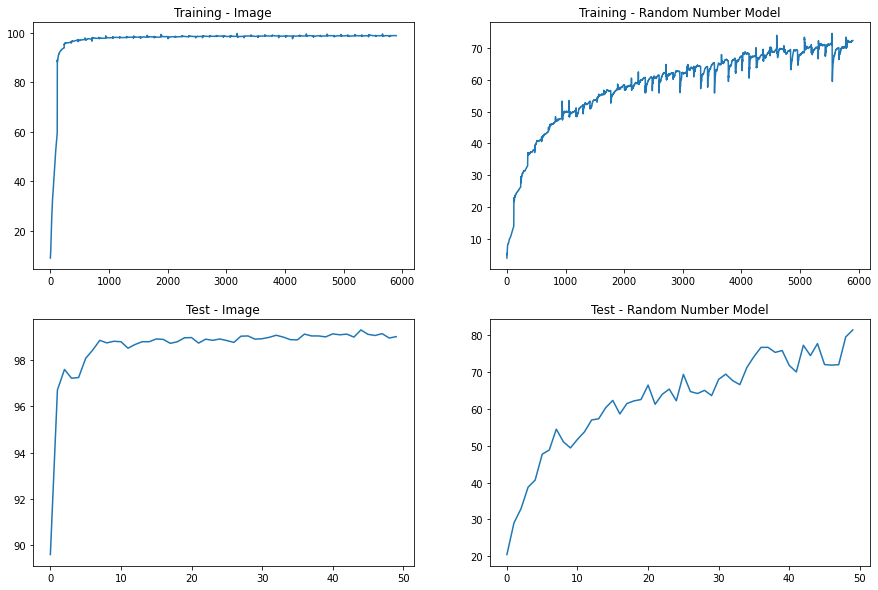

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))

axs[0, 0].plot(train_acc['Image'][:])
axs[0, 0].set_title("Training - Image")
axs[0, 1].plot(train_acc['RandomNumber'][:])
axs[0, 1].set_title("Training - Random Number Model")
axs[1, 0].plot(test_acc['Image'][:])
axs[1, 0].set_title("Test - Image")
axs[1, 1].plot(test_acc['RandomNumber'][:])
axs[1, 1].set_title("Test - Random Number Model")